<a href="https://colab.research.google.com/github/ZzzzzzT233/PCA/blob/main/05_PCA/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

In [7]:
! git clone https://www.github.com/DS3001/PCA

Cloning into 'PCA'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 12), reused 13 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 2.42 MiB | 8.31 MiB/s, done.
Resolving deltas: 100% (12/12), done.


### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [1]:
import pandas as pd
import pickle
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from multiprocessing.pool import Pool
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


To clean the data, I focus only on meaningful tokens and remove others such as "the" and punctuation. Then, I use one-hot encoding to represent the presence or absence of each token as features for machine learning. Finally, I apply a linear model to these features, possibly using dimensionality reduction techniques like PCA, to predict whether an email is a phishing scam.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [9]:
with open('./PCA/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

In [15]:
gdf = pd.DataFrame(token_freq, columns = ['token', 'count'])
gdf.head()

,token,count
0,new,1365
1,date,1202
2,get,1052
3,please,1022
4,enron,927


<Axes: >

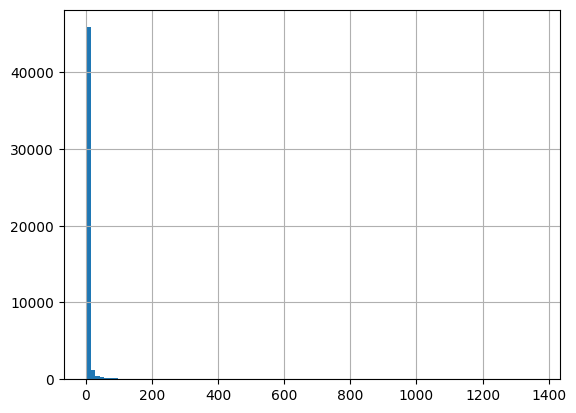

In [12]:
gdf['count'].hist(bins = 100)

In [13]:
gdf['count'].describe()

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [23]:
# df = pd.read_parquet('./PCA/05_PCA/Phishing_clean.parquet')

y = df['Email Type']
X = df.drop(columns = ['Email Type'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

y_test_0 = model.predict(X_test)
y_train_0 = model.predict(X_train)
r2_test = r2_score(y_test_0, y_test)
r2_train = r2_score(y_train_0, y_train)
print("Train:",r2_test)
print("Test:",r2_train)

result = pd.DataFrame({'variable':model.feature_names_in_, 'value':np.abs(model.coef_)})
result.sort_values('value',ascending=False)

Train: -0.00026838432670373
Test: 0.6210107280960204


,variable,value
710,1997,1.415784e+13
421,1995,1.158467e+13
1133,"19,",1.025713e+13
340,2005,9.773947e+12
1146,-0400,8.062341e+12
...,...,...
1399,union,2.822876e-04
565,east,2.746582e-04
2268,ravages,1.068115e-04
457,due,6.484985e-05


### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

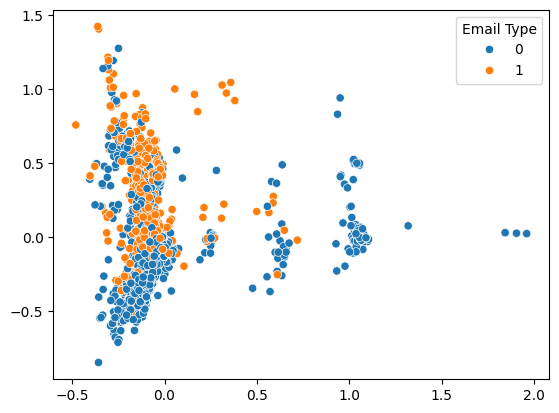

In [25]:
reduction = PCA(n_components=2).fit(X_train)
X_train_2 = reduction.transform(X_train)
X_test_2 = reduction.transform(X_test)
sns.scatterplot(x=X_test_2[:,0],y=X_test_2[:,1],hue=y_test)

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [26]:
reduction = PCA(n_components=2610).fit(X_train)
X_train_3 = reduction.transform(X_train)
X_test_3 = reduction.transform(X_test)

model = LinearRegression()
model.fit(X_train_3, y_train)

y_test_0 = model.predict(X_test_3)
y_train_0 = model.predict(X_train_3)
r2_test = r2_score(y_test_0, y_test)
r2_train = r2_score(y_train_0, y_train)
print('Train:', r2_score(y_train_0,y_train) )
print('Test',r2_score(y_test_0,y_test) )

Train: 0.692897536096375
Test 0.5873905973217184


### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.